# Practical Homework 4_Unsupervised Learning
## Lavanya Bundari, Erdenetuya Namsrai

In [113]:
# Load libraries and Functions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.datasets import get_rdataset
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from numpy.linalg import svd
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from ISLP import load_data
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib.colors import ListedColormap
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import cut_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.cluster.hierarchy import cut_tree, dendrogram
from sklearn.preprocessing import LabelEncoder

# 1. Data preparation

## 1.1 Main Dataset: Prevalence of adult overweight obesity among adults in countries around the world

In [114]:
# Prepare data

obesity_data = pd.read_csv('adult_obesity.csv', encoding='latin1')
#obesity_data = pd.read_csv('https://raw.githubusercontent.com/erdenetuya2080/DATA5322-Machine-Learning-II/main/Practical%20Homework%20IV_Unsupervised%20Learning/Datasets/adult_obesity.csv', encoding='latin1')

# Data clean
obesity_clean = obesity_data[[
    'Country',
    'Year',
    'Age',
    'Males Overweight (BMI 25-29.9kg/m²)',
    'Males Obesity (BMI ?30kg/m²)',
    'Females Overweight (BMI 25-29.9kg/m²)',
    'Females Obesity (BMI ?30kg/m²)',
    'Adults Overweight (BMI 25-29.9kg/m²)',
    'Adults Obesity (BMI ?30kg/m²)'
]].rename(columns={
    'Males Overweight (BMI 25-29.9kg/m²)': 'Males_Overweight',
    'Males Obesity (BMI ?30kg/m²)': 'Males_Obesity',
    'Females Overweight (BMI 25-29.9kg/m²)': 'Females_Overweight',
    'Females Obesity (BMI ?30kg/m²)': 'Females_Obesity',
    'Adults Overweight (BMI 25-29.9kg/m²)': 'Adults_Overweight',
    'Adults Obesity (BMI ?30kg/m²)': 'Adults_Obesity'
})
cols_to_fix = ['Males_Overweight', 'Males_Obesity', 'Females_Overweight', 'Females_Obesity', 'Adults_Overweight', 'Adults_Obesity']

for col in cols_to_fix:
    obesity_clean[col] = obesity_clean[col].str.replace(',', '.', regex=False)
    obesity_clean[col] = pd.to_numeric(obesity_clean[col], errors='coerce')
    
# Drop missing rows
obesity_clean = obesity_clean.dropna()
obesity_clean = obesity_clean.dropna(subset=cols_to_fix)

# Filter only adult groups starting with '18' 
obesity_clean = obesity_clean[obesity_clean['Age'].str.contains(r'^18', na=False)]

# Drop the Age column since we only kept adult rows
obesity_clean = obesity_clean.drop(columns=['Age'])

# Extract only the starting ("2017-2018" → 2017)
obesity_clean['Year'] = obesity_clean['Year'].str.extract(r'(\d{4})').astype(int)
obesity_clean.info()
obesity_clean.head()

<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 0 to 247
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country             80 non-null     object 
 1   Year                80 non-null     int32  
 2   Males_Overweight    80 non-null     float64
 3   Males_Obesity       80 non-null     float64
 4   Females_Overweight  80 non-null     float64
 5   Females_Obesity     80 non-null     float64
 6   Adults_Overweight   80 non-null     float64
 7   Adults_Obesity      80 non-null     float64
dtypes: float64(6), int32(1), object(1)
memory usage: 5.3+ KB


,Country,Year,Males_Overweight,Males_Obesity,Females_Overweight,Females_Obesity,Adults_Overweight,Adults_Obesity
0,Afghanistan,2018,25.9,11.9,25.6,23.5,25.8,17.0
2,Algeria,2016,34.2,14.1,33.2,30.1,33.8,21.8
4,Andorra,2017,42.5,13.0,27.0,14.4,35.2,13.6
6,Anguilla,2016,36.0,30.4,27.4,46.5,31.7,38.5
8,Argentina,2018,38.7,31.4,29.1,33.4,33.7,32.4


Result: The resulting dataset is a clean, numeric collection of adult only obesity indicators, including male, female, and overall overweight and obesity rates, organized by country and year.

## 1.2 Supporting Dataset: World Development Indicators

In [115]:
# Prepare data

world_data=pd.read_csv('World_data.csv')

#world_data = pd.read_csv('https://raw.githubusercontent.com/erdenetuya2080/DATA5322-Machine-Learning-II/main/Practical%20Homework%20IV_Unsupervised%20Learning/Datasets/world_data.csv')

# Drop unnecessary columns
world_data_cleaned = world_data.drop(columns=['Country Code', 'Series Code'])

world_long = pd.melt(
    world_data_cleaned,
    id_vars=['Country Name', 'Series Name'],
    var_name='Year',
    value_name='Value'
)

# Extract numeric year
world_long['Year'] = world_long['Year'].str.extract(r'(\d{4})').astype('Int64')

# Drop rows with missing key identifiers
world_long = world_long.dropna(subset=['Country Name', 'Series Name'])

# Replace '..' with NaN and convert Value column to numeric
world_long['Value'] = pd.to_numeric(world_long['Value'], errors='coerce')

# Pivot the table so each indicator becomes a column
world_wide = world_long.pivot_table(
    index=['Country Name', 'Year'],
    columns='Series Name',
    values='Value'
).reset_index()

# Clean column names 
world_wide.columns.name = None  # remove the pivoted name
world_wide.columns = [col.strip().replace(' ', '_') for col in world_wide.columns]

# Renaming
world_wide = world_wide.rename(columns={
    'Current_health_expenditure_per_capita_(current_US$)': 'Health_Expenditure',
    'GDP_per_capita_(current_US$)': 'GDP_Per_Capita',
    'Literacy_rate,_adult_total_(%_of_people_ages_15_and_above)': 'Literacy_Rate',
    'Physicians_(per_1,000_people)': 'Physicians_per_1000',
    'Urban_population_(%_of_total_population)': 'Urban_Pop_Percent'
})
# Dropping NA values
world_wide_cleaned = world_wide.dropna(subset=[
    'Country_Name',
    'Year',
    'Health_Expenditure',
    'GDP_Per_Capita',
    'Literacy_Rate',
    'Physicians_per_1000',
    'Urban_Pop_Percent'
])
# Convert numeric columns from string to float
columns_to_convert = ['Health_Expenditure', 'GDP_Per_Capita', 'Literacy_Rate', 'Physicians_per_1000', 'Urban_Pop_Percent']

for col in columns_to_convert:
    world_wide_cleaned[col] = pd.to_numeric(world_wide_cleaned[col], errors='coerce')

# Drop any new NaNs that appear due to conversion
world_wide_cleaned = world_wide_cleaned.dropna(subset=columns_to_convert)
world_wide_cleaned.info()
world_wide_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
Index: 612 entries, 11 to 6067
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country_Name         612 non-null    object 
 1   Year                 612 non-null    Int64  
 2   Health_Expenditure   612 non-null    float64
 3   GDP_Per_Capita       612 non-null    float64
 4   Literacy_Rate        612 non-null    float64
 5   Physicians_per_1000  612 non-null    float64
 6   Urban_Pop_Percent    612 non-null    float64
dtypes: Int64(1), float64(5), object(1)
memory usage: 38.8+ KB


C:\Users\erden\AppData\Local\Temp\ipykernel_20624\2416946910.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  world_wide_cleaned[col] = pd.to_numeric(world_wide_cleaned[col], errors='coerce')


,Country_Name,Year,Health_Expenditure,GDP_Per_Capita,Literacy_Rate,Physicians_per_1000,Urban_Pop_Percent
11,Afghanistan,2011,52.187218,606.694676,31.000000,0.259000,23.948000
15,Afghanistan,2015,59.919605,565.569730,33.753841,0.291000,24.803000
33,Africa Eastern and Southern,2010,104.119647,1601.727748,64.809998,0.104126,32.195595
43,Africa Eastern and Southern,2020,81.551895,1344.080962,72.855759,0.218133,36.884034
46,Africa Western and Central,2000,18.199851,516.932316,47.577381,0.192887,35.341698


Result: This dataset contains clean, numeric, country-level indicators such as health expenditure, GDP per capita, literacy rate, physician density, and urban population percentage by year.

## 1.3 Merge Datasets

In [116]:
# World Bank entry per country
latest_world = world_wide_cleaned.sort_values('Year').drop_duplicates('Country_Name', keep='last')

# Merge on Country only
obesity_world_finaldata = pd.merge(
    obesity_clean,
    latest_world,
    left_on='Country',
    right_on='Country_Name',
    how='inner'
)

# Drop unwanted columns
obesity_world_finaldata.drop(columns=['Country_Name', 'Year_y'], inplace=True)

# Rename Year_x to Year
obesity_world_finaldata.rename(columns={'Year_x': 'Year'}, inplace=True)

# Check results
print("Shape of final obesity world dataset:", obesity_world_finaldata.shape)
obesity_world_finaldata.info()
obesity_world_finaldata.head()

Shape of final obesity world dataset: (51, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country              51 non-null     object 
 1   Year                 51 non-null     int32  
 2   Males_Overweight     51 non-null     float64
 3   Males_Obesity        51 non-null     float64
 4   Females_Overweight   51 non-null     float64
 5   Females_Obesity      51 non-null     float64
 6   Adults_Overweight    51 non-null     float64
 7   Adults_Obesity       51 non-null     float64
 8   Health_Expenditure   51 non-null     float64
 9   GDP_Per_Capita       51 non-null     float64
 10  Literacy_Rate        51 non-null     float64
 11  Physicians_per_1000  51 non-null     float64
 12  Urban_Pop_Percent    51 non-null     float64
dtypes: float64(11), int32(1), object(1)
memory usage: 5.1+ KB


,Country,Year,Males_Overweight,Males_Obesity,Females_Overweight,Females_Obesity,Adults_Overweight,Adults_Obesity,Health_Expenditure,GDP_Per_Capita,Literacy_Rate,Physicians_per_1000,Urban_Pop_Percent
0,Afghanistan,2018,25.9,11.9,25.6,23.5,25.8,17.0,59.919605,565.569730,33.753841,0.2910,24.803
1,Algeria,2016,34.2,14.1,33.2,30.1,33.8,21.8,271.537781,4577.210292,81.407837,1.7320,72.629
2,Argentina,2018,38.7,31.4,29.1,33.4,33.7,32.4,668.793091,7141.475077,97.000000,3.2481,89.329
3,Armenia,2016,31.4,14.0,25.1,25.0,28.2,19.5,409.801453,3869.053739,100.000000,2.9720,63.103
4,Azerbaijan,2017,38.8,14.7,30.9,26.5,34.8,20.6,199.257462,4805.753718,100.000000,3.1110,56.031


Result: The final merged dataset combines adult obesity rates with the most recent country-level indicators such as GDP, health expenditure, and literacy rate, resulting in a dataset with 51 records and 13 variables.

# 2. Standardization 

In [117]:
# Prepare data

# Drop non-numeric columns
numeric_obesity_world_data = obesity_world_finaldata.select_dtypes(include=['float64', 'int64'])

# Standardize the features
scaler = StandardScaler()
scaled_obesity_world_data = scaler.fit_transform(numeric_obesity_world_data)

Result: We removed non-numeric columns and scaled the numeric data so that all features have the same range. This step is important because it makes sure that no single feature unfairly influences the results in clustering analysis.

# 3. SVD (Singular Value Decomposition)

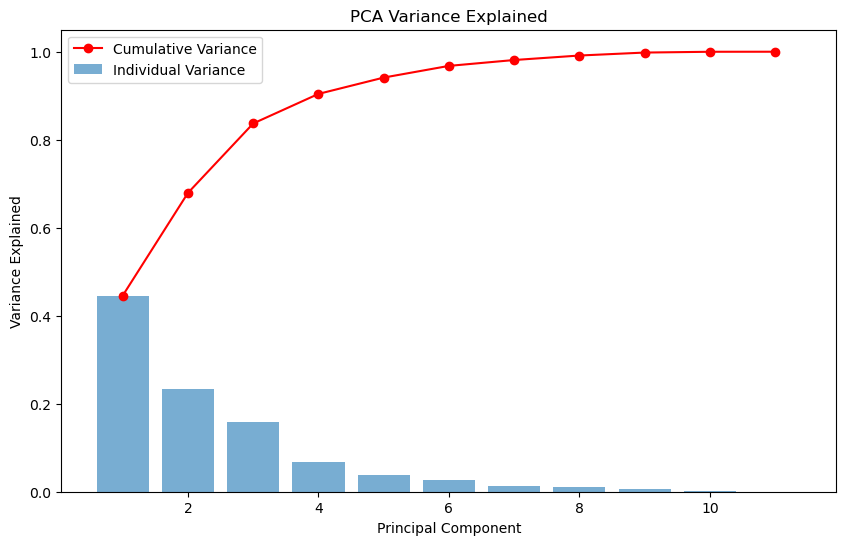

In [118]:
# SVD
U, s, Vt = svd(scaled_obesity_world_data, full_matrices=False)

# Fit PCA
pca = PCA()
pca_obesity_world_data = pca.fit_transform(scaled_obesity_world_data)

# Compute explained variance ratio
variance_explained = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(range(1, len(variance_explained)+1), variance_explained, alpha=0.6, label='Individual Variance')
ax1.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', color='r', label='Cumulative Variance')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Variance Explained')
ax1.set_title('PCA Variance Explained')
ax1.legend()
plt.show()

Result: The plot shows that the first few principal components capture the majority of the variance in the dataset. Specifically, the first principal component explains the largest proportion of variance individually, and the cumulative variance increases rapidly with the addition of the next few components. By the time five components are included, over 95% of the total variance is explained. This suggests that the dimensionality of the dataset can be significantly reduced without substantial loss of information, enabling more efficient analysis and visualization while preserving the essential structure of the data.  

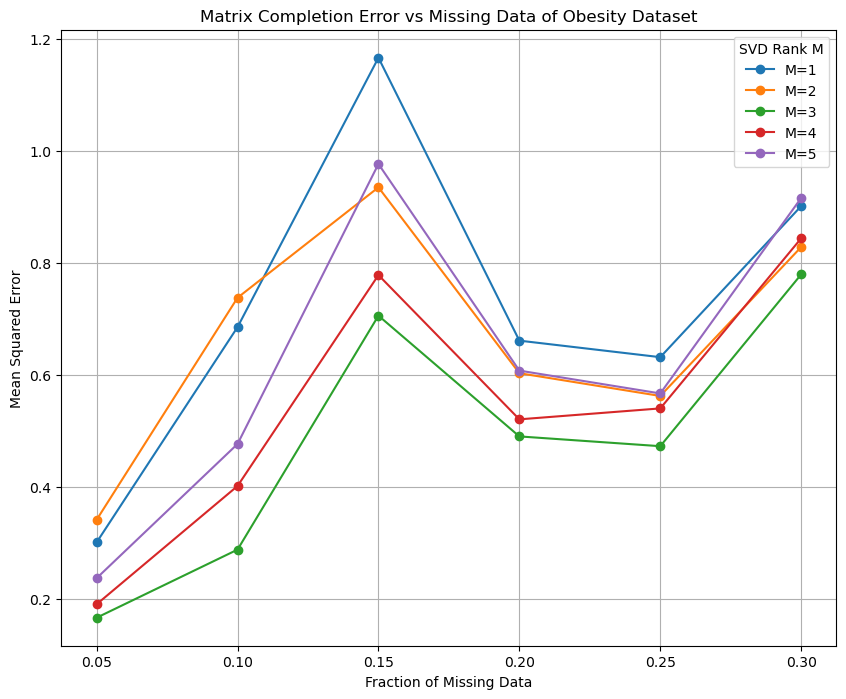

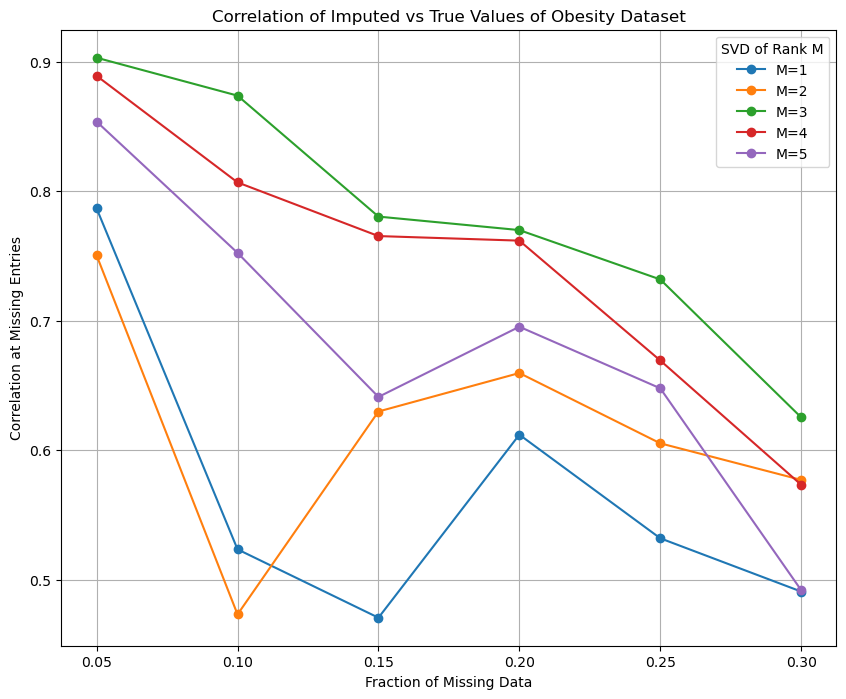

In [119]:
# Parameters
missing_rates = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
ranks = range(1, 6)  

# Containers
mse_results = {rank: [] for rank in ranks}
corr_results = {rank: [] for rank in ranks}

# Matrix Completion using low-rank SVD
def svd_impute(X_missing, rank):
    df = pd.DataFrame(X_missing)
    
    # Fix: fill missing values with column-wise means
    X_filled = df.fillna(df.mean()).values

    # Perform SVD
    U, s, Vt = svd(X_filled, full_matrices=False)
    S_k = np.diag(s[:rank])
    X_approx = U[:, :rank] @ S_k @ Vt[:rank, :]
    return X_approx

# Loop through missing rates and ranks
for p in missing_rates:
    mask = np.random.rand(*scaled_obesity_world_data.shape) < p
    X_missing = scaled_obesity_world_data.copy()
    X_missing[mask] = np.nan
    
    for r in ranks:
        X_imputed = svd_impute(X_missing, r)

        # Evaluate only on missing entries
        true_vals = scaled_obesity_world_data[mask]
        pred_vals = X_imputed[mask]

        mse = mean_squared_error(true_vals, pred_vals)
        corr, _ = pearsonr(true_vals, pred_vals)

        mse_results[r].append(mse)
        corr_results[r].append(corr)

# Plot MSE
plt.figure(figsize=(10, 8))
for r in ranks:
    plt.plot(missing_rates, mse_results[r], marker='o', label=f'M={r}')
plt.xlabel("Fraction of Missing Data")
plt.ylabel("Mean Squared Error")
plt.title("Matrix Completion Error vs Missing Data of Obesity Dataset")
plt.legend(title="SVD Rank M")
plt.grid(True)

# Plot Correlation
plt.figure(figsize=(10, 8))
for r in ranks:
    plt.plot(missing_rates, corr_results[r], marker='o', label=f'M={r}')
plt.xlabel("Fraction of Missing Data")
plt.ylabel("Correlation at Missing Entries")
plt.title("Correlation of Imputed vs True Values of Obesity Dataset")
plt.legend(title="SVD of Rank M")
plt.grid(True)
plt.show()

Result: The MSE plot shows that SVD can effectively recover missing data, especially when the missing rate is low. Using 3 components, rank = 3 gives the best overall results, with low error even when up to 30% of the data is missing. This suggests that a small number of components is enough to capture the key structure in the obesity dataset and reliably fill in missing values. The correlation plot shows that low-rank SVD can accurately guess missing values, especially when using 3 or 4 components. These ranks give strong and stable correlations with the true data, even as more values are missing. This means we can recover most of the important structure in the dataset using just a few key components.

# 4. PCA (Principal Component Analysis)

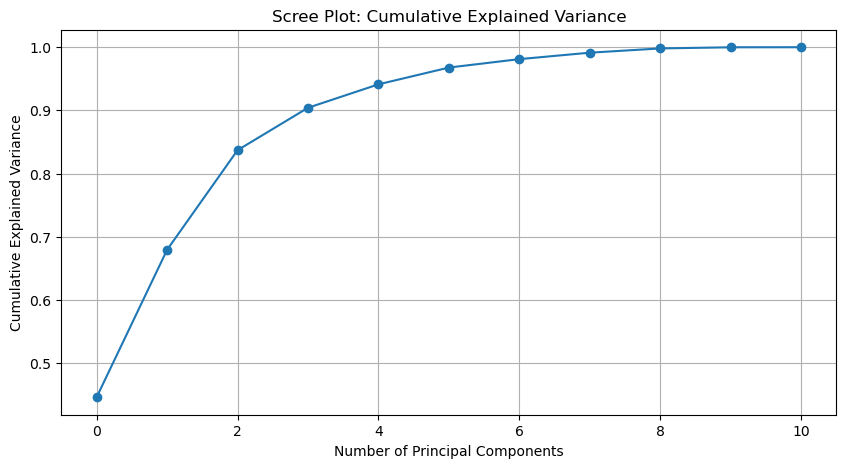

In [120]:
# Fit PCA
pca = PCA()
pca_obesity_world_data = pca.fit_transform(scaled_obesity_world_data)

# Explained variance
explained_variance = pca.explained_variance_ratio_
explained_variance

# Scree plot
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.title("Scree Plot: Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

Result: PCA shows how much information each component holds. The scree plot helps us choose the right number of components to simplify the data while keeping most of its meaning. We can see in the result, we only need about 4 components to keep most of the important information. This makes the data simpler and easier to work with without losing much meaning.

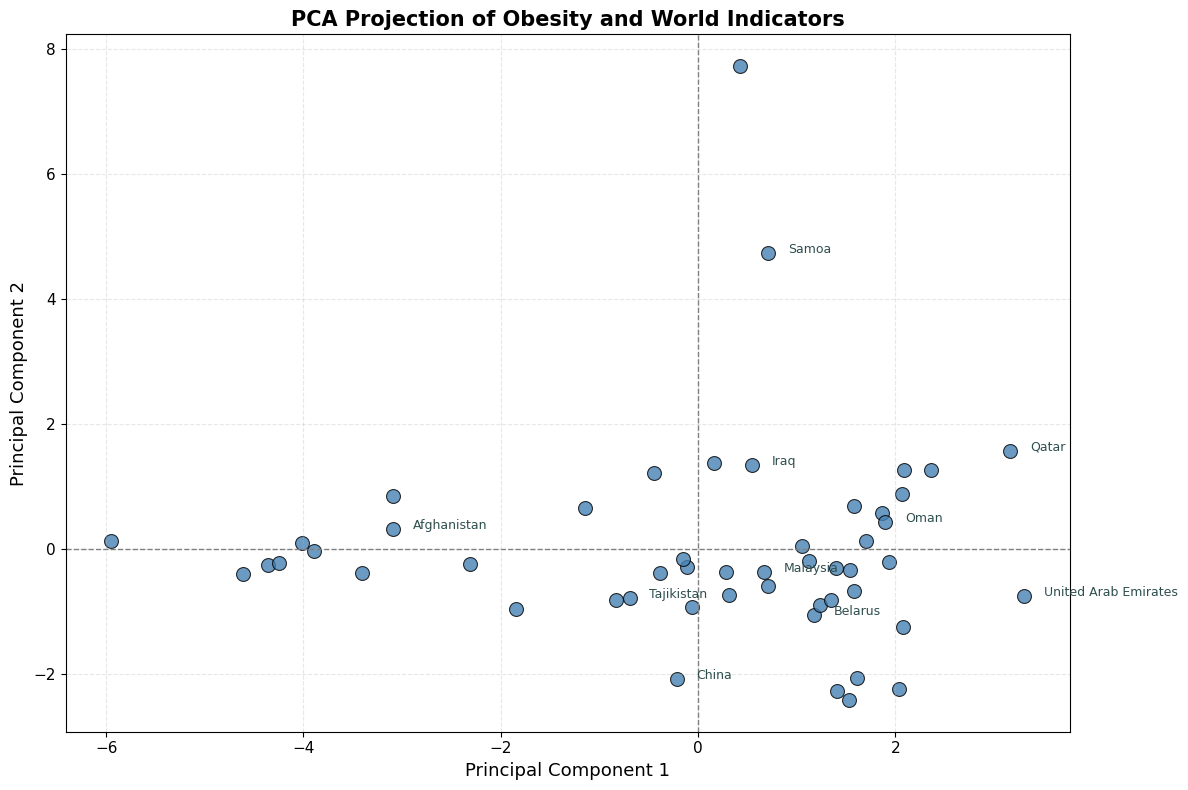

In [121]:
# 2D scatter plot on the first two principal components

# Plot
plt.figure(figsize=(12, 8))

sns.scatterplot(
    x=pca_obesity_world_data[:, 0],
    y=pca_obesity_world_data[:, 1],
    s=100,  # larger marker for better visibility
    edgecolor='black',
    alpha=0.8,
    color='steelblue'
)

# Axis lines at origin
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)

# Annotate selected points to avoid clutter
for i, country in enumerate(obesity_world_finaldata['Country']):
    if i % 6 == 0 or pca_obesity_world_data[i, 0] > 3:  
        plt.text(pca_obesity_world_data[i, 0] + 0.2,
                 pca_obesity_world_data[i, 1],
                 country,
                 fontsize=9,
                 color='darkslategray')

# Result
plt.title('PCA Projection of Obesity and World Indicators', fontsize=15, fontweight='bold')
plt.xlabel('Principal Component 1', fontsize=13)
plt.ylabel('Principal Component 2', fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Result: This 2D scatter plot shows how countries compare based on obesity and world indicators using the top two PCA components. The countries are projected onto the first two principal components derived from key socioeconomic and health indicators. Principal Component 1 primarily reflects economic development variables such as GDP per capita and health expenditure, while Principal Component 2 captures variations in obesity prevalence independent of wealth. The scatter plot highlights similarities and differences in country profiles based on these combined factors. 

# 5. K-Means Clustering

In [122]:
# k-means cluster

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_obesity_world_data)

obesity_world_finaldata["Cluster"] = kmeans_labels

C:\Users\erden\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


C:\Users\erden\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


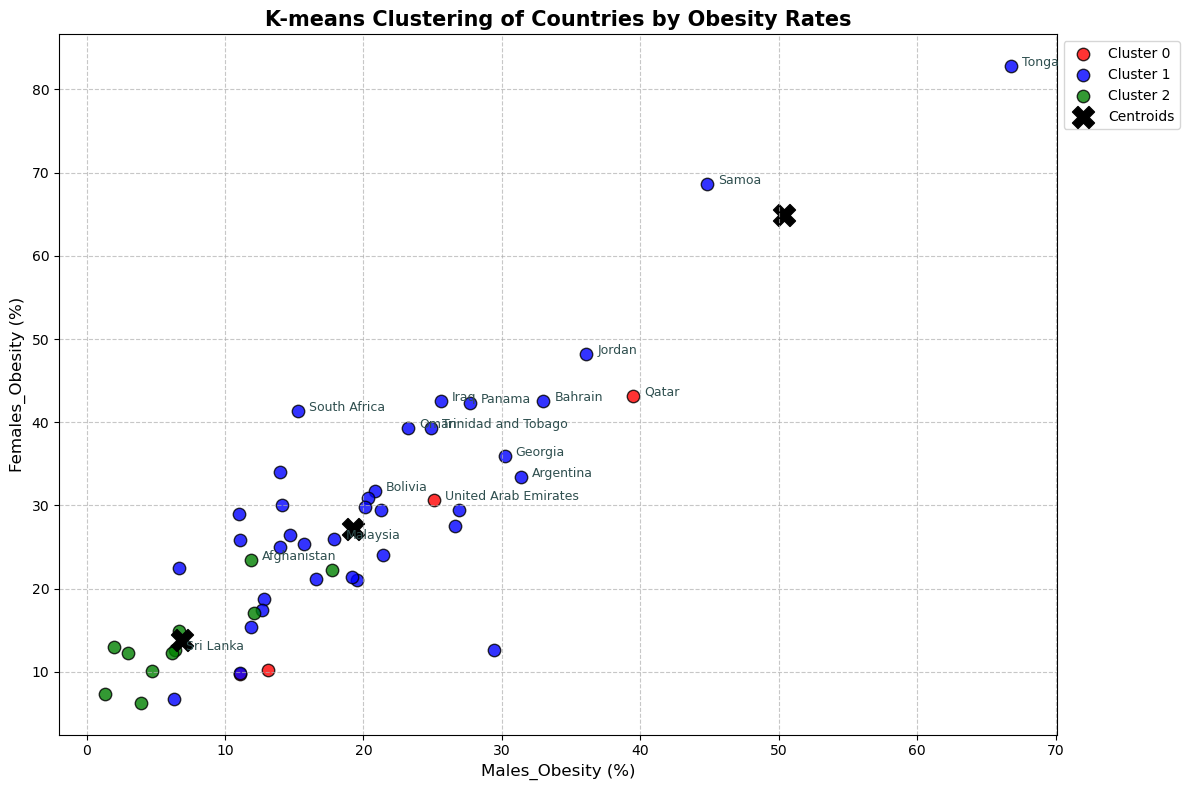

In [123]:
# Select numeric features
features = obesity_world_finaldata.select_dtypes(include='number').drop(columns=['Cluster'], errors='ignore')

# Inverse transform centroids back to original scale
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=0)  
kmeans.fit(scaled_features)

# Inverse transform the cluster centers
centroid_values = scaler.inverse_transform(kmeans.cluster_centers_)
centroid_columns = features.columns[:centroid_values.shape[1]]  
centroids_df = pd.DataFrame(centroid_values, columns=centroid_columns)

# Extract X and Y for plotting
centroids_x = centroids_df["Males_Obesity"]
centroids_y = centroids_df["Females_Obesity"]

# Define colors
fixed_colors = ['red', 'blue', 'green']

# Plot
plt.figure(figsize=(12, 8))

# Plot each cluster separately
for idx, cluster_label in enumerate(sorted(obesity_world_finaldata["Cluster"].unique())):
    cluster_data = obesity_world_finaldata[obesity_world_finaldata["Cluster"] == cluster_label]
    plt.scatter(
        cluster_data["Males_Obesity"],
        cluster_data["Females_Obesity"],
        color=fixed_colors[idx],
        label=f'Cluster {cluster_label}',
        s=80,
        edgecolor='k',
        alpha=0.8
    )

# Plot centroids
plt.scatter(
    centroids_x,
    centroids_y,
    c='black',
    s=250,
    marker='X',
    label='Centroids'
)

# Annotate selected countries
for i, row in obesity_world_finaldata.iterrows():
    if i % 8 == 0 or row["Males_Obesity"] > 30 or row["Females_Obesity"] > 35:
        plt.text(
            row["Males_Obesity"] + 0.8,
            row["Females_Obesity"],
            row["Country"],
            fontsize=9,
            color='darkslategray'
        )

# Labels and Layout
plt.xlabel("Males_Obesity (%)", fontsize=12)
plt.ylabel("Females_Obesity (%)", fontsize=12)
plt.title("K-means Clustering of Countries by Obesity Rates", fontsize=15, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Result: This plot shows the grouping of countries into three clusters based on similarities in obesity rates, using plain (original) data without dimensionality reduction. The clustering was performed directly on the male and female obesity percentages to maintain interpretability. The resulting plot displays these clusters with each color representing a different group, while the black 'X' markers indicate the cluster centroids (average obesity rates for each group). Outliers like Tonga and Samoa stand out with exceptionally high obesity rates, whereas other countries form tighter clusters with more similar obesity profiles.

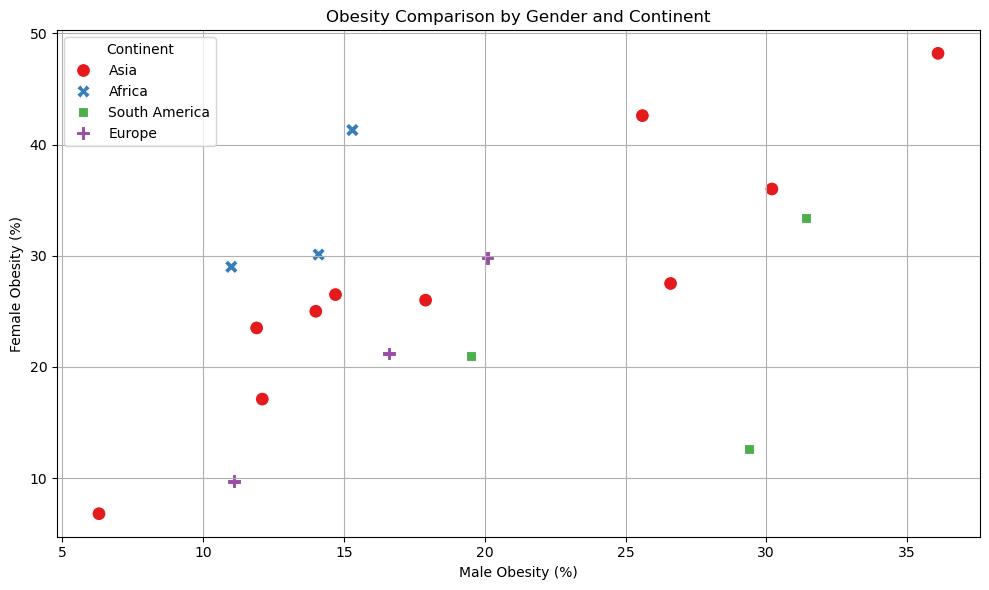

In [124]:
# Obesity Comparison by Gender and Continent

continent_map = {
    'Afghanistan': 'Asia',
    'Algeria': 'Africa',
    'Argentina': 'South America',
    'Armenia': 'Asia',
    'Azerbaijan': 'Asia',
    'Bangladesh': 'Asia',
    'Belarus': 'Europe',
    'Brazil': 'South America',
    'Cambodia': 'Asia',
    'China': 'Asia',
    'Colombia': 'South America',
    'Croatia': 'Europe',
    'Czech Republic': 'Europe',
    'Denmark': 'Europe',
    'Egypt': 'Africa',
    'Estonia': 'Europe',
    'Ethiopia': 'Africa',
    'Finland': 'Europe',
    'France': 'Europe',
    'Georgia': 'Asia',
    'Germany': 'Europe',
    'Greece': 'Europe',
    'Hungary': 'Europe',
    'India': 'Asia',
    'Indonesia': 'Asia',
    'Iran': 'Asia',
    'Iraq': 'Asia',
    'Israel': 'Asia',
    'Italy': 'Europe',
    'Japan': 'Asia',
    'Jordan': 'Asia',
    'Kazakhstan': 'Asia',
    'Kenya': 'Africa',
    'Kuwait': 'Asia',
    'Kyrgyzstan': 'Asia',
    'Latvia': 'Europe',
    'Lebanon': 'Asia',
    'Lithuania': 'Europe',
    'Malaysia': 'Asia',
    'Mexico': 'North America',
    'Morocco': 'Africa',
    'Pakistan': 'Asia',
    'Philippines': 'Asia',
    'Poland': 'Europe',
    'Portugal': 'Europe',
    'Russia': 'Europe',
    'South Africa': 'Africa',
    'Spain': 'Europe',
    'Thailand': 'Asia',
    'Turkey': 'Asia',
    'Ukraine': 'Europe'
}

obesity_world_finaldata["Continent"] = obesity_world_finaldata["Country"].map(continent_map)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=obesity_world_finaldata,
    x="Males_Obesity",
    y="Females_Obesity",
    hue="Continent",           
    style="Continent",         
    palette="Set1",
    s=100
)
plt.title("Obesity Comparison by Gender and Continent")
plt.xlabel("Male Obesity (%)")
plt.ylabel("Female Obesity (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

Result: This plot compares male and female obesity across continents (51 countries), revealing regional patterns and gender differences. It shows that while some continents have balanced obesity rates between men and women, Asia shows more variation. 

C:\Users\erden\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


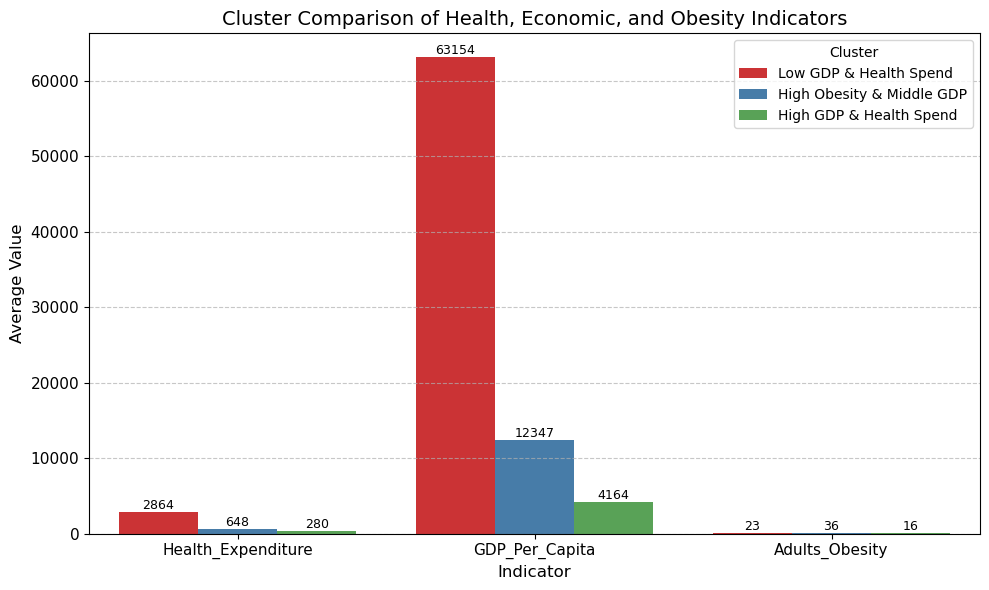

In [125]:
# Cluster Comparison of Health, Economic, and Obesity Indicators

# Selected features
cluster_features = ["Health_Expenditure", "GDP_Per_Capita", "Adults_Obesity"]
X = obesity_world_finaldata[cluster_features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
obesity_world_finaldata["Cluster_Selected"] = kmeans.fit_predict(X_scaled)

# Summarize cluster profiles
cluster_summary = obesity_world_finaldata.groupby("Cluster_Selected")[cluster_features + ["Continent"]].agg({
    "Health_Expenditure": "mean",
    "GDP_Per_Capita": "mean",
    "Adults_Obesity": "mean",
    "Continent": lambda x: x.value_counts().idxmax()
}).round(2)

# Rename clusters for interpretability
cluster_labels = {
    0: "Low GDP & Health Spend",
    1: "High Obesity & Middle GDP",
    2: "High GDP & Health Spend"
}
cluster_summary.rename(index=cluster_labels, inplace=True)

# Data
plot_data = cluster_summary.reset_index().melt(
    id_vars='Cluster_Selected',
    value_vars=cluster_features,
    var_name='Variable',
    value_name='Average Value'
)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=plot_data,
    x="Variable",
    y="Average Value",
    hue="Cluster_Selected",
    palette="Set1"
)

# Annotate values on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=9)

# Result
plt.title("Cluster Comparison of Health, Economic, and Obesity Indicators", fontsize=14)
plt.xlabel("Indicator", fontsize=12)
plt.ylabel("Average Value", fontsize=12)
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title="Cluster", title_fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Result: This analysis grouped countries into 3 meaningful clusters based on health spending, economic wealth, and obesity rates. This comparison plot shows that countries with higher health spending tend to have lower obesity rates, while those with moderate GDP and low spending show the highest obesity levels.

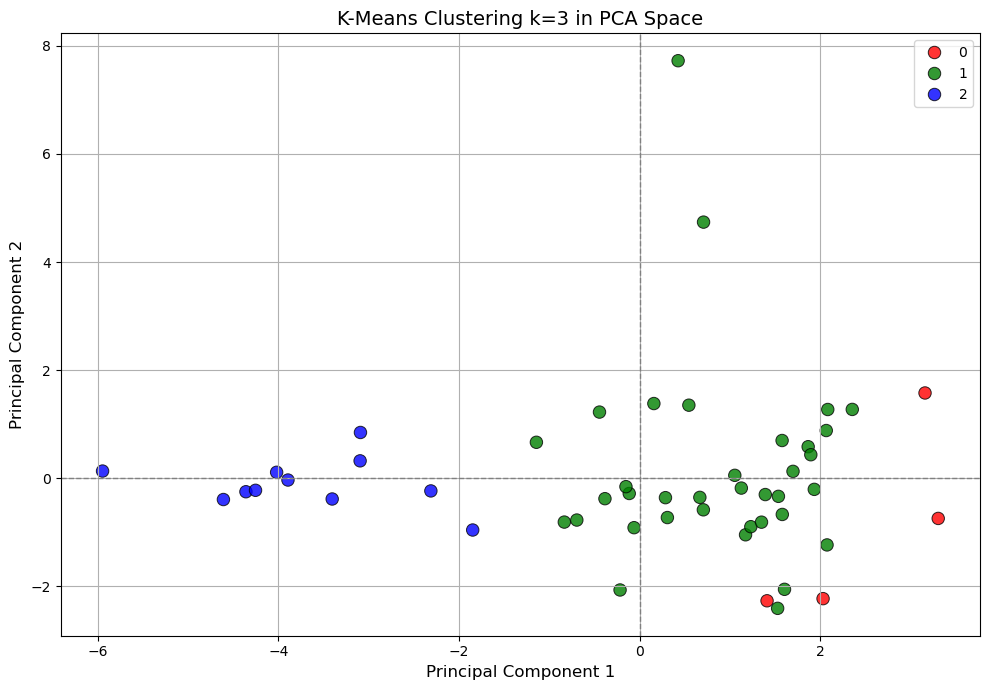

Silhouette Score: 0.3844888901893602


In [126]:
# Visualizes K-Means clustering results

# Color palette
rgb_palette = ['red', 'green', 'blue']

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=pca_obesity_world_data[:, 0],
    y=pca_obesity_world_data[:, 1],
    hue=kmeans_labels,
    palette=rgb_palette,
    s=80,
    edgecolor='k',
    alpha=0.8
)

# Axis lines
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.title("K-Means Clustering k=3 in PCA Space", fontsize=14)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Silhouette score
print("Silhouette Score:", silhouette_score(scaled_obesity_world_data, kmeans_labels))

Result: This plot shows how K-Means divided countries into three distinct groups based on health, economy, and obesity patterns. While one group (green) is large and diverse, another (blue) is more tightly packed, suggesting stronger similarity. The red group includes outliers or countries with unique profiles. 

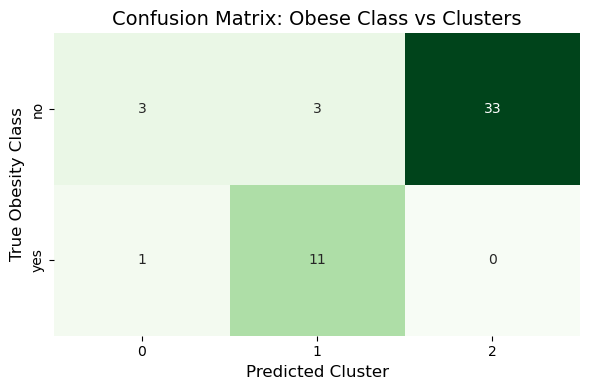

Confusion Matrix (Table):
Predicted Cluster   0   1   2
True Obesity Class           
no                  3   3  33
yes                 1  11   0


In [127]:
# Confusion Matrix: Obese Class vs Clusters

# Create binary class label from Adults_Obesity: "yes" if obesity rate is >= 30%, else "no"
obesity_world_finaldata["Obese_Class"] = obesity_world_finaldata["Adults_Obesity"].apply(
    lambda x: "yes" if x >= 30 else "no"
)

# Confusion matrix
confusion_matrix = pd.crosstab(
    obesity_world_finaldata["Obese_Class"],
    obesity_world_finaldata["Cluster_Selected"],
    rownames=["True Obesity Class"],
    colnames=["Predicted Cluster"]
)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Confusion Matrix: Obese Class vs Clusters", fontsize=14)
plt.xlabel("Predicted Cluster", fontsize=12)
plt.ylabel("True Obesity Class", fontsize=12)
plt.tight_layout()
plt.show()

# Result
print("Confusion Matrix (Table):")
print(confusion_matrix)

Result: This confusion matrix shows that K-Means clustering does a good job separating obese and non-obese countries. Cluster 2 captures most non-obese cases, while Cluster 1 captures most obese ones. A small overlap in Cluster 0 suggests a few countries have mixed characteristics. 

C:\Users\erden\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\erden\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\erden\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\erden\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Window

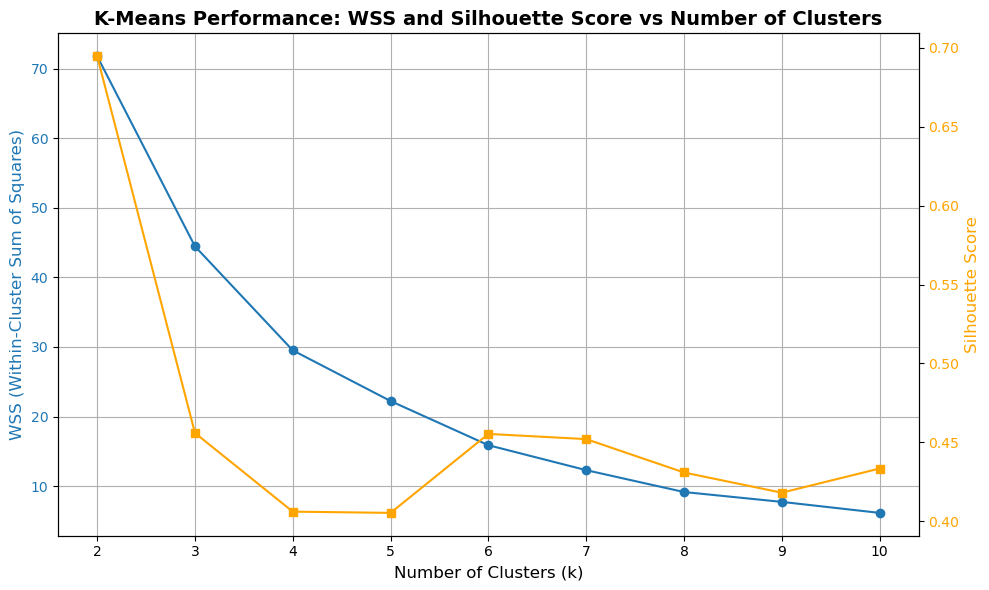

C:\Users\erden\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


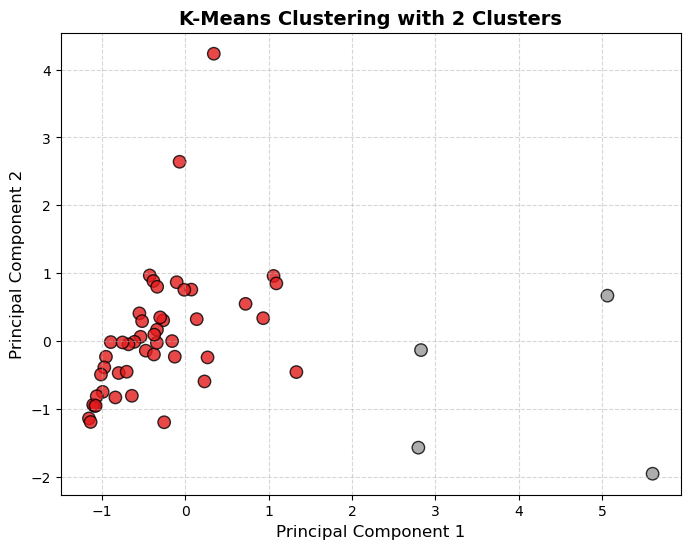

C:\Users\erden\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


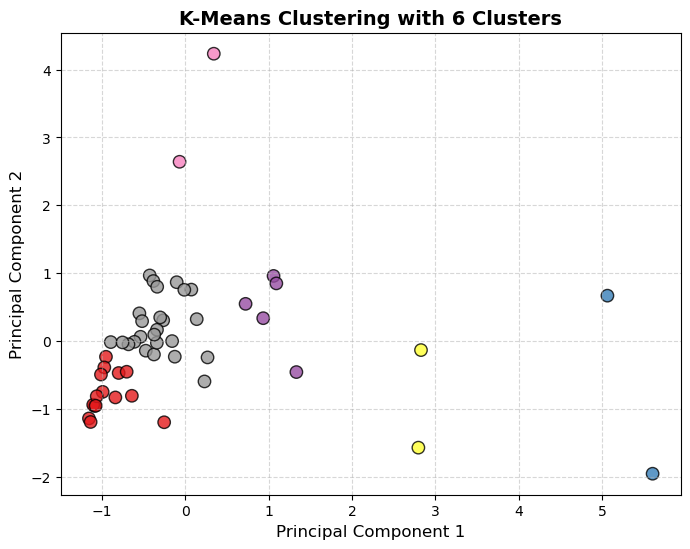

In [128]:
# Evaluating Optimal Clusters Using PCA, WSS, and Silhouette Score for Country Obesity

# Select features 
features = ["Health_Expenditure", "GDP_Per_Capita", "Adults_Obesity"]
X = obesity_world_finaldata[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# WSS and Silhouette Score Evaluation
k_values = range(2, 11)
wss = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1)
    cluster_labels = kmeans.fit_predict(X_pca)
    wss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, cluster_labels))

# Plot WSS and Silhouette Score
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot WSS
color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('WSS (Within-Cluster Sum of Squares)', color=color, fontsize=12)
ax1.plot(k_values, wss, marker='o', color=color, label='WSS')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title("K-Means Performance: WSS and Silhouette Score vs Number of Clusters", fontsize=14, fontweight='bold')
ax1.grid(True)

# Plot Silhouette Score on second y-axis
ax2 = ax1.twinx()
color = 'orange'
ax2.set_ylabel('Silhouette Score', color=color, fontsize=12)
ax2.plot(k_values, silhouette_scores, marker='s', color=color, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

# Plot Clustering Results for k=2 and k=6
def plot_clusters(X_pca, n_clusters, title):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=1)
    cluster_labels = kmeans.fit_predict(X_pca)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        X_pca[:, 0], X_pca[:, 1],
        c=cluster_labels, cmap='Set1', s=80, edgecolor='k', alpha=0.8
    )
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Plot for k=2 and k=6
plot_clusters(X_pca, 2, "K-Means Clustering with 2 Clusters")
plot_clusters(X_pca, 6, "K-Means Clustering with 6 Clusters")

Result: These plots suggest that k = 2 provides the best-defined clusters, as indicated by the highest Silhouette Score. However, the WSS curve shows 
a noticeable elbow at k = 3 and a smaller improvement in cluster compactness beyond that point. Additionally, k = 6 shows a secondary improvement in the Silhouette Score compared to other higher k values, suggesting that it may capture finer sub-group structures. Finally, k = 2 appears optimal if the goal is to form well-separated, clearly defined clusters, while k = 3 or k = 6 may offer a balance between compactness and discovering more nuanced groupings. The final choice of k should depend on the specific application and desired granularity of the analysis.

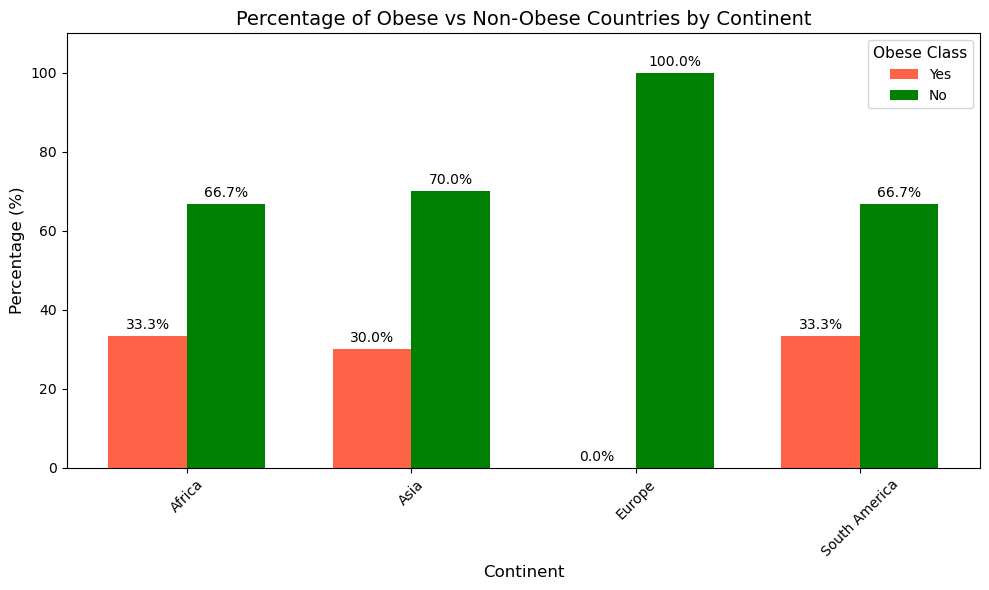

In [129]:
continent_counts = (
    obesity_world_finaldata.groupby("Continent")["Obese_Class"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0) * 100
)

continent_counts = continent_counts[["yes", "no"]]

x = np.arange(len(continent_counts))  
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, continent_counts["yes"], width, label='Yes', color='tomato')
bars2 = ax.bar(x + width/2, continent_counts["no"], width, label='No', color='green')

for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), 
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

# Formatting
ax.set_title("Percentage of Obese vs Non-Obese Countries by Continent", fontsize=14)
ax.set_xlabel("Continent", fontsize=12)
ax.set_ylabel("Percentage (%)", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(continent_counts.index, rotation=45)
ax.legend(title="Obese Class", title_fontsize=11)
ax.set_ylim(0, 110) 
plt.tight_layout()
plt.show()


Result: This plot shows that the proportion of obese countries (where adult obesity is ≥ 30%) is significantly higher in Africa, Asia, and South America compared to Europe. It is clear that Europe has no countries with high obesity.

# 6. Hierarchical Clustering

In [131]:
# Randomly sample 40 countries
sampled_obesity_data = obesity_world_finaldata.sample(n=40, random_state=42)

# Set 'Country' as index AFTER sampling
sampled_obesity_data = sampled_obesity_data.set_index("Country")

# Select features for clustering
features_for_subset = ["Health_Expenditure", "GDP_Per_Capita", "Adults_Obesity"]
subset_obesity = sampled_obesity_data[features_for_subset]

# Standardize features
scaler = StandardScaler()
subset_obesity_scaled = scaler.fit_transform(subset_obesity)

In [132]:
# Complete linkage
HClust = AgglomerativeClustering
hc_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')
hc_complete.fit(subset_obesity_scaled)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        n_clusters=None)

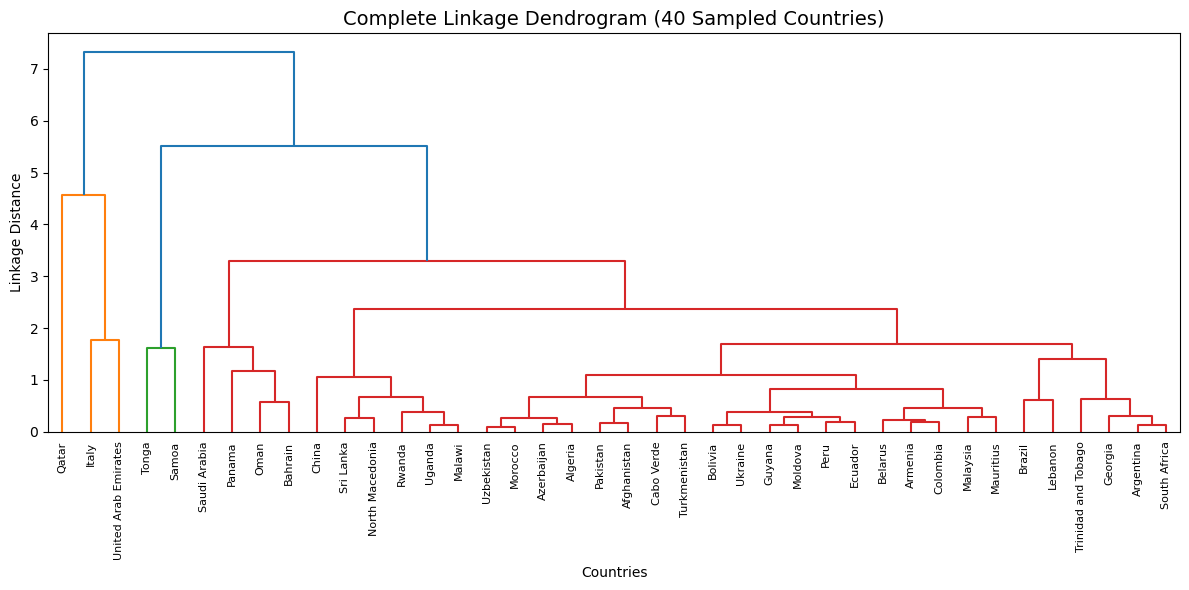

In [133]:
#Create linkage matrix
def create_linkage_matrix(model):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                count += 1
            else:
                count += counts[child_idx - n_samples]
        counts[i] = count
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    return linkage_matrix

# Create Complete Linkage matrix
linkage_complete = create_linkage_matrix(hc_complete)

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(
    linkage_complete,
    labels=sampled_obesity_data.index.tolist(),  # <- Country names
    leaf_rotation=90      
)
plt.title("Complete Linkage Dendrogram (40 Sampled Countries)", fontsize=14)
plt.xlabel("Countries")
plt.ylabel("Linkage Distance")
plt.tight_layout()
plt.show()

Result: This dendrogram shows how 40 countries can be grouped based on health, economic, and obesity indicators. Some countries are very similar and cluster early, while others are quite different and only join at higher distances.

In [134]:
# Average linkage
HClust = AgglomerativeClustering
hc_average = HClust(distance_threshold=0, n_clusters=None, linkage='average')
hc_average.fit(subset_obesity_scaled)

AgglomerativeClustering(distance_threshold=0, linkage='average',
                        n_clusters=None)

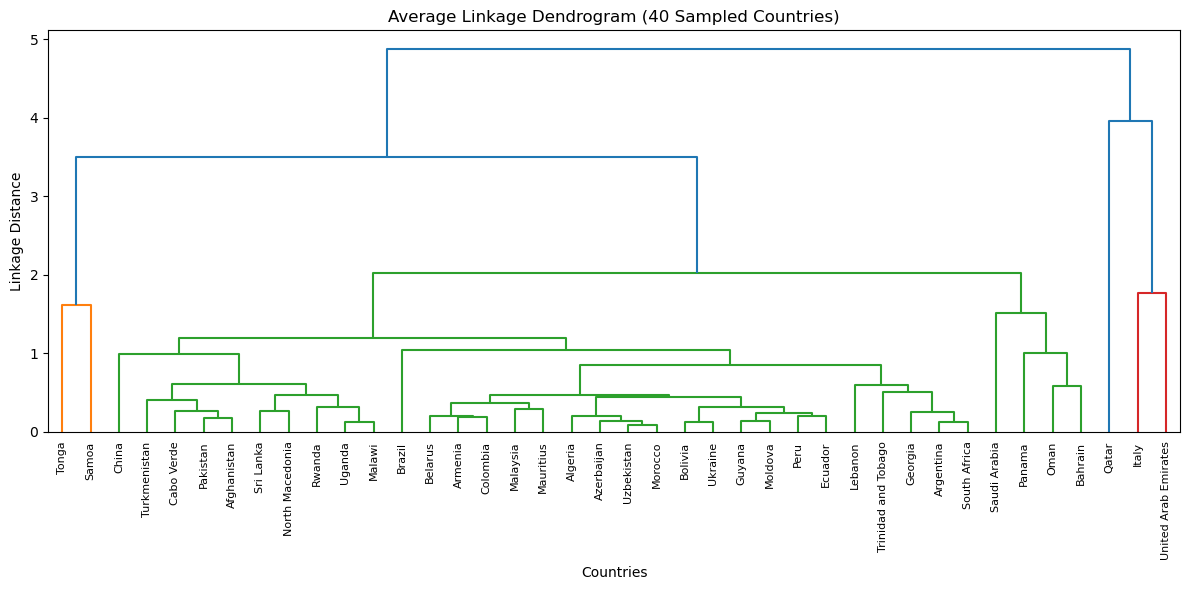

In [135]:
# Create an Average linkage matrix
linkage_average = create_linkage_matrix(hc_average)
# Plot dendrogram 
plt.figure(figsize=(12, 6))
dendrogram(
    linkage_average,
    labels=sampled_obesity_data.index.tolist(),  
    leaf_rotation=90
)
plt.title("Average Linkage Dendrogram (40 Sampled Countries)")
plt.xlabel("Countries")
plt.ylabel("Linkage Distance")
plt.tight_layout()
plt.show()

Result: This dendrogram using average linkage shows that the 40 countries can be grouped into 3 main clusters based on their health, economic, and obesity data. Countries in the same cluster are more similar to each other, while those merged at higher points are more different.

In [136]:
# Single linkage
HClust = AgglomerativeClustering
hc_single = HClust(distance_threshold=0, n_clusters=None, linkage='single')
hc_single.fit(subset_obesity_scaled)

AgglomerativeClustering(distance_threshold=0, linkage='single', n_clusters=None)

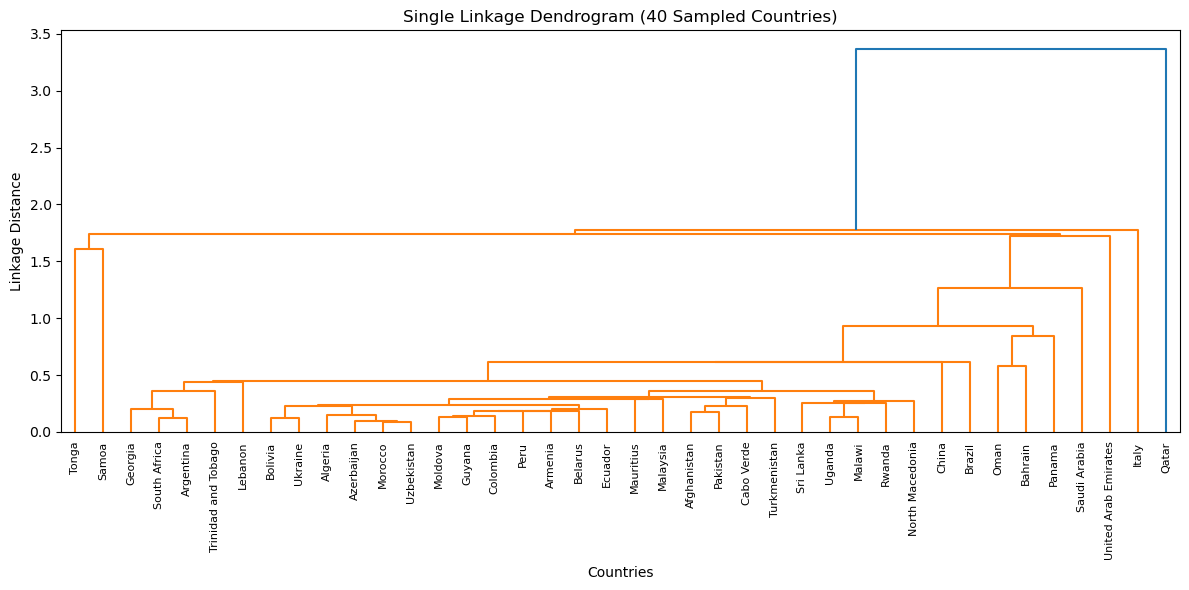

In [137]:
# Create a Single-linkage matrix
linkage_single = create_linkage_matrix(hc_single)

plt.figure(figsize=(12, 6))
dendrogram(
    linkage_single,
    labels=sampled_obesity_data.index.tolist(),  
    leaf_rotation=90
)
plt.title("Single Linkage Dendrogram (40 Sampled Countries)")
plt.xlabel("Countries")
plt.ylabel("Linkage Distance")
plt.tight_layout()
plt.show()

Result: This dendrogram shows that the 40 countries can be divided into 2 main groups based on health and economic indicators. Countries in the same group are more similar, while the two clusters are quite different from each other.

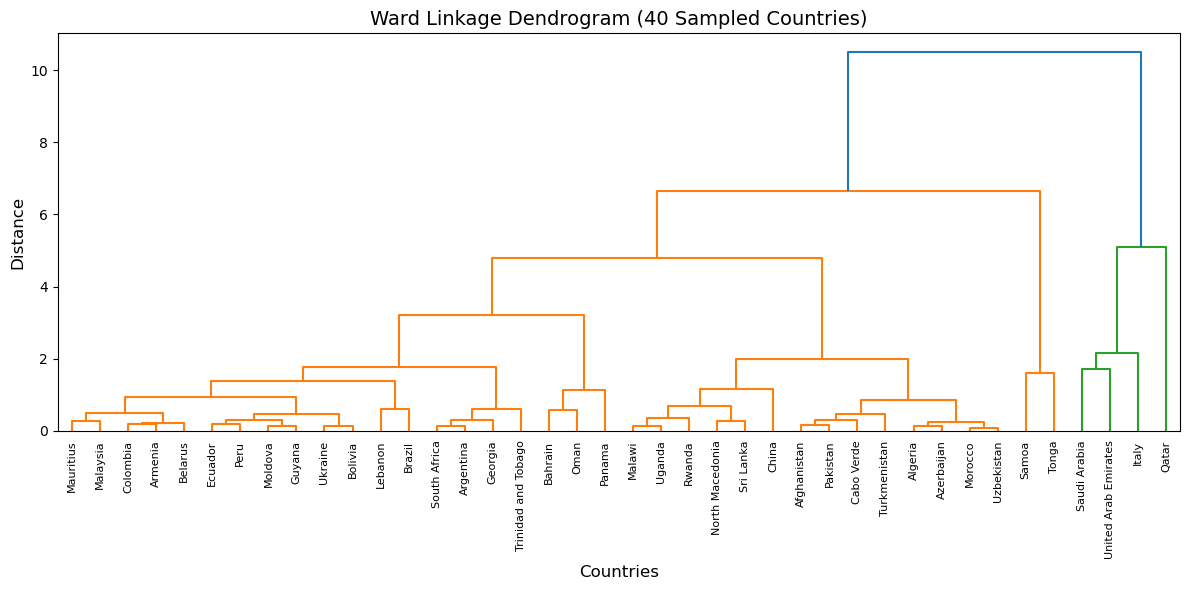

In [138]:
# Perform hierarchical clustering using Ward's method
linked = linkage(subset_obesity_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(
    linked,
    labels=sampled_obesity_data.index.tolist(),  
    leaf_rotation=90,
    distance_sort='descending',
    show_leaf_counts=True
)

# Result
plt.title("Ward Linkage Dendrogram (40 Sampled Countries)", fontsize=14)
plt.xlabel("Countries", fontsize=12)
plt.ylabel("Distance", fontsize=12)
plt.tight_layout()
plt.show()

Result: This Ward linkage dendrogram shows that the 40 countries can be grouped into 3 main clusters based on similarities in health, economy, and obesity. Countries in the same cluster are more similar to each other, while those that merge higher up are more different. 

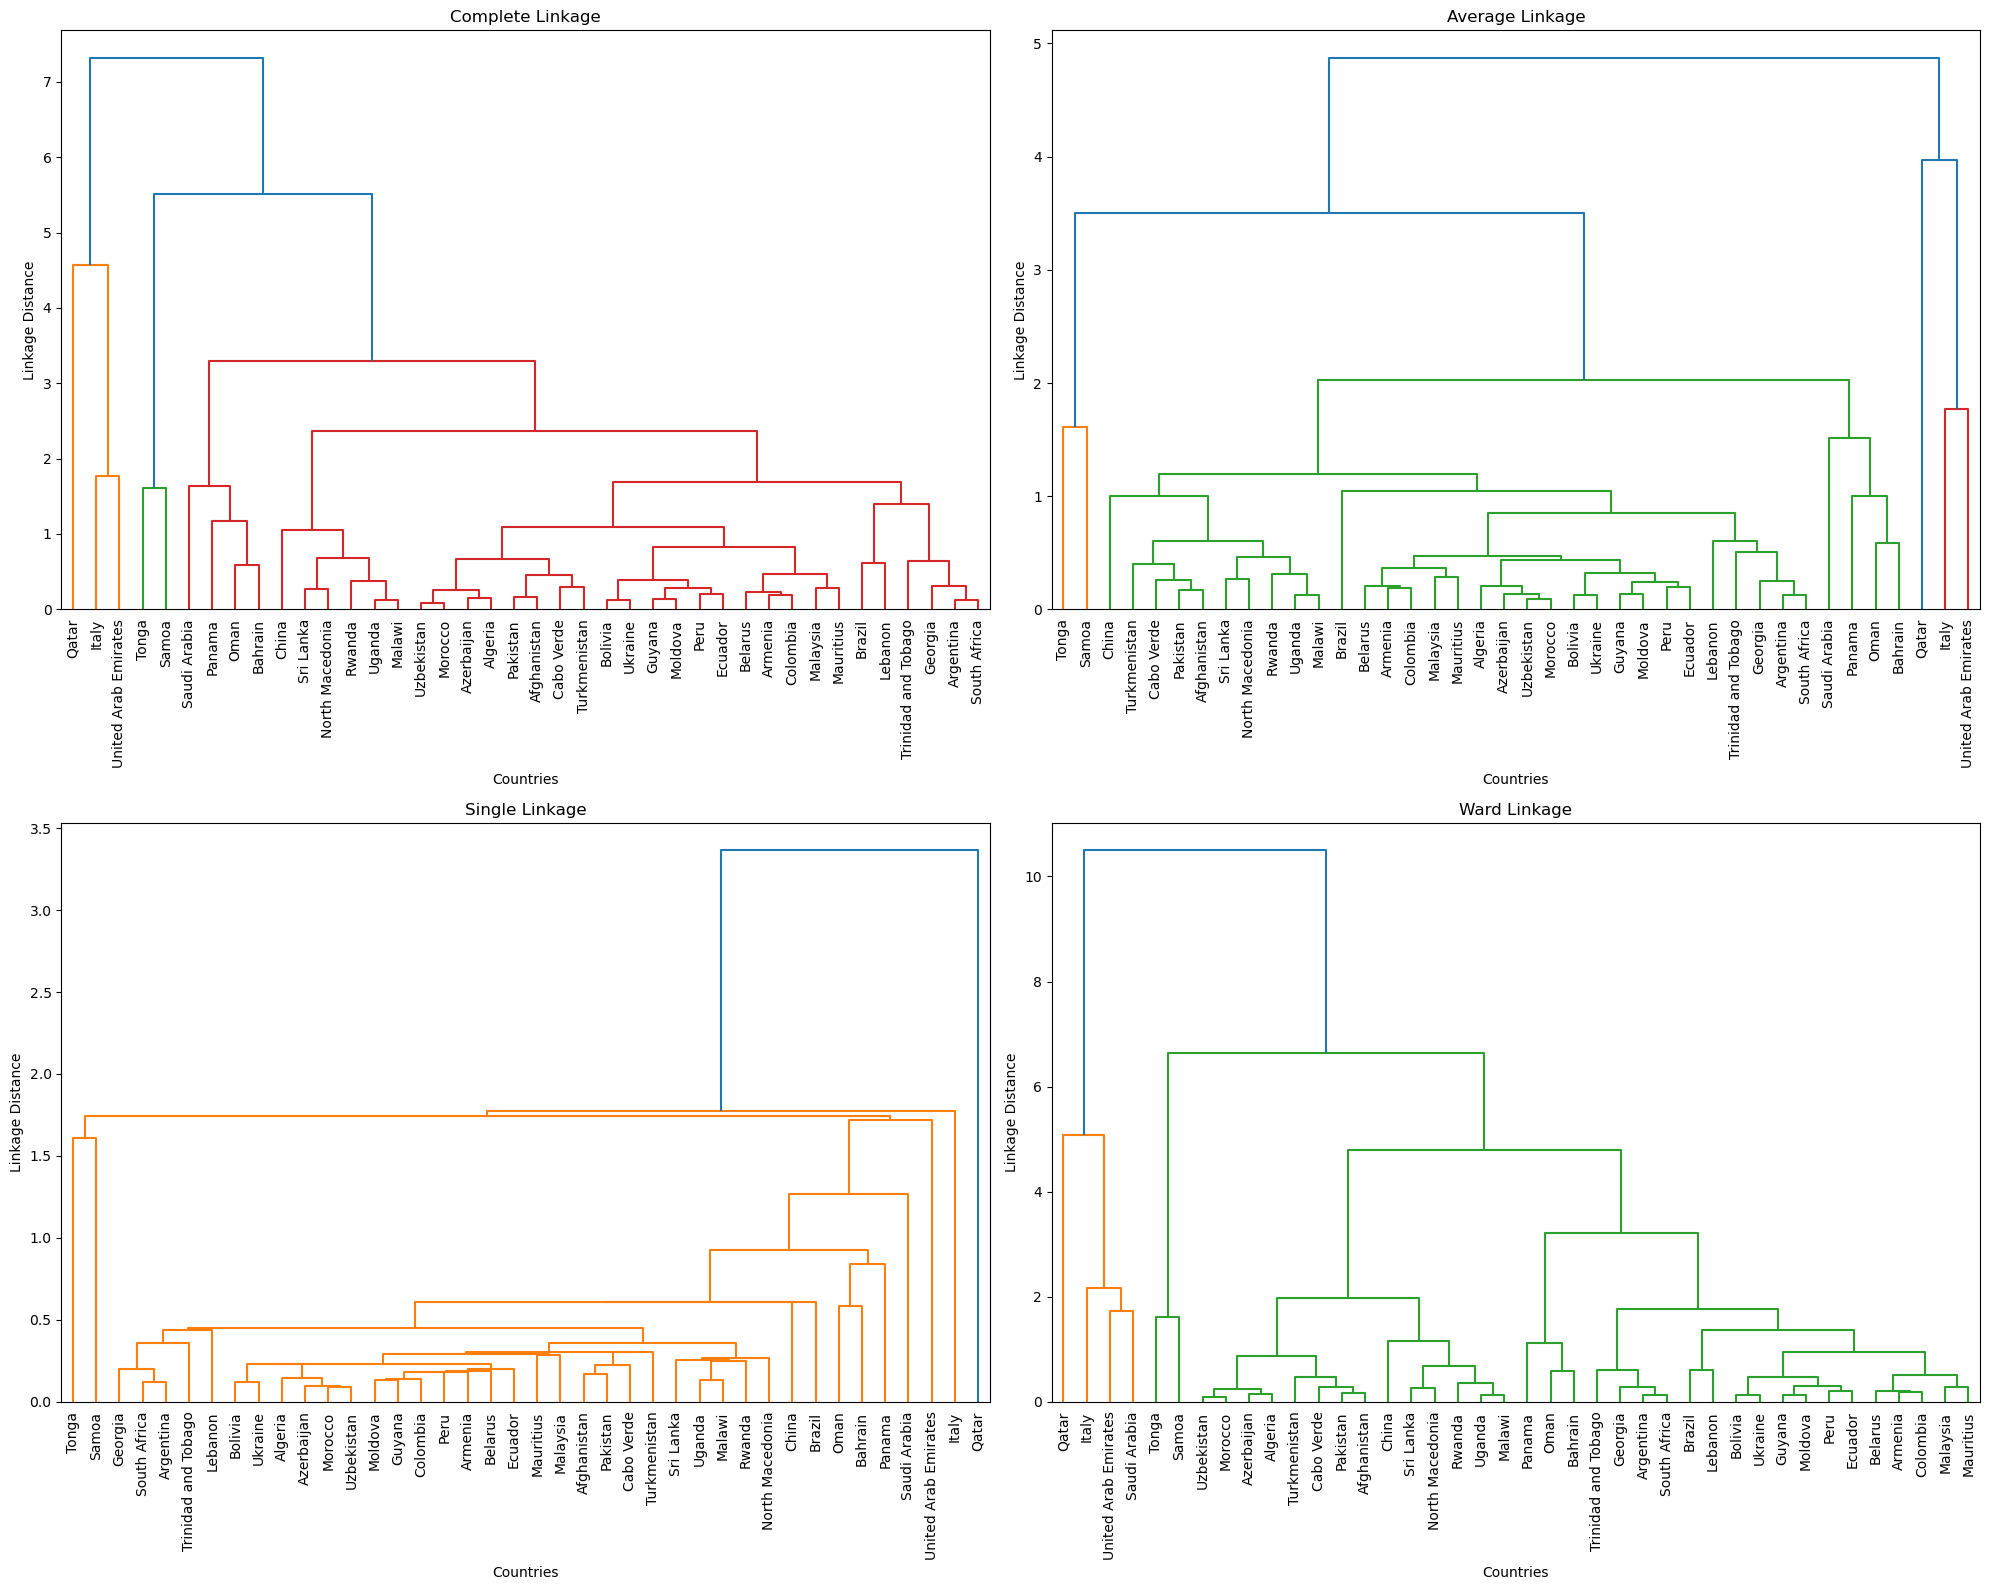

In [139]:
# Comparative Dendrogram Visualization for Four Linkage Methods
linkage_methods = ['complete', 'average', 'single', 'ward']
linkage_matrices = {}

# Linkage Matrices
for method in linkage_methods:
    hc = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=method)
    hc.fit(subset_obesity_scaled)
    linkage_matrices[method] = create_linkage_matrix(hc)

# Plot dendrograms
plt.figure(figsize=(20, 16))
for i, method in enumerate(linkage_methods, start=1):
    plt.subplot(2, 2, i)
    dendrogram(
        linkage_matrices[method],
        labels=sampled_obesity_data.index.tolist(),  
        leaf_rotation=90,
        leaf_font_size=10
    )
    plt.title(f"{method.capitalize()} Linkage")
    plt.xlabel("Countries")
    plt.ylabel("Linkage Distance")
plt.tight_layout()
plt.show()

Result: Ward and Complete linkage create the clearest and most balanced groupings of countries. Average linkage is okay, but Single linkage is not very useful here, it forms long, messy chains instead of clear groups. So, Ward linkage is the best choice in here. 


Countries in Cluster 1:
['Tonga', 'Samoa']

Countries in Cluster 2:
['Sri Lanka', 'Uganda', 'China', 'Malaysia', 'Pakistan', 'Guyana', 'Armenia', 'Colombia', 'Bolivia', 'Uzbekistan', 'Belarus', 'Ukraine', 'Azerbaijan', 'Peru', 'Ecuador', 'Brazil', 'Georgia', 'Moldova', 'Trinidad and Tobago', 'Mauritius', 'Cabo Verde', 'Afghanistan', 'Turkmenistan', 'Morocco', 'North Macedonia', 'Algeria', 'Lebanon', 'Argentina', 'South Africa', 'Rwanda', 'Malawi']

Countries in Cluster 3:
['Panama', 'Oman', 'Bahrain', 'Saudi Arabia']

Countries in Cluster 4:
['Italy', 'United Arab Emirates']

Countries in Cluster 5:
['Qatar']


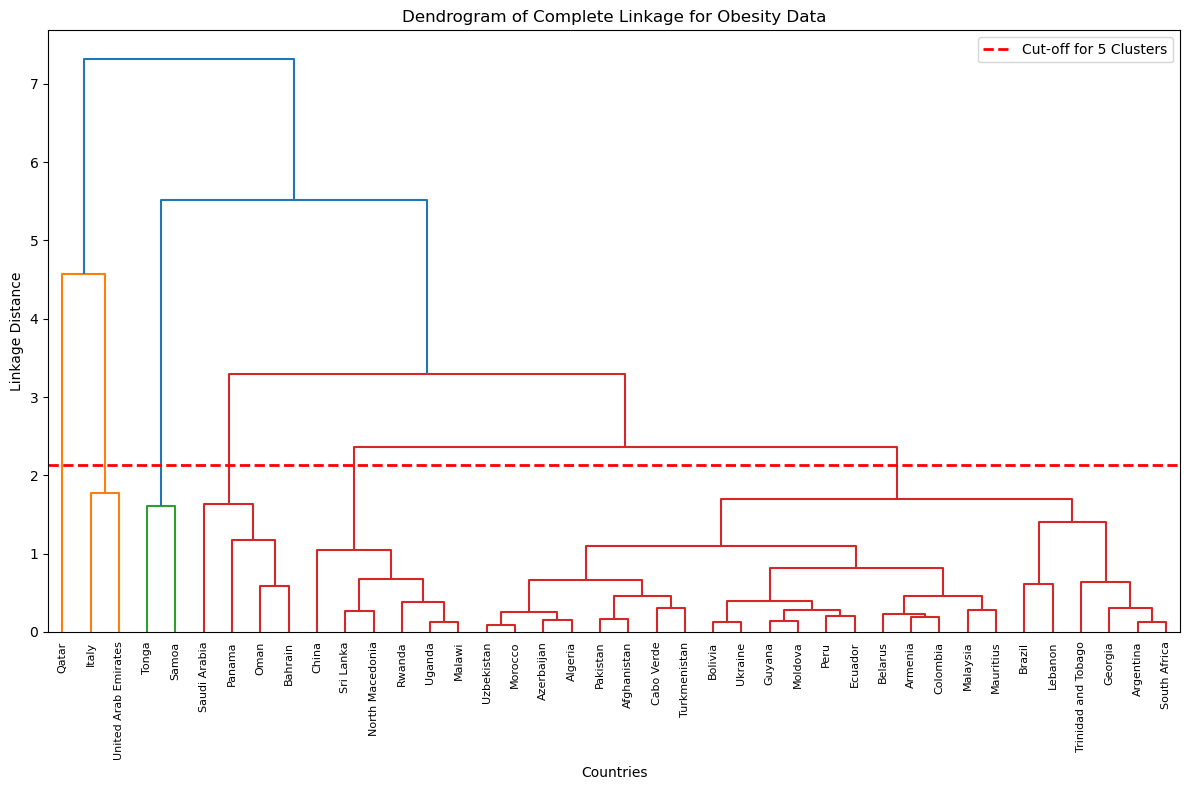

In [140]:
num_clusters = 5

# Cut the dendrogram into clusters
cluster_labels = cut_tree(linkage_complete, n_clusters=num_clusters).flatten()

# Assign clusters 
sampled_obesity_data['Cluster'] = cluster_labels + 1

# Print countries in each cluster
for i in range(1, num_clusters + 1):
    countries = sampled_obesity_data.index[sampled_obesity_data['Cluster'] == i].to_list()
    print(f"\nCountries in Cluster {i}:")
    print(countries)

# Plot dendrogram
plt.figure(figsize=(12, 8))
dendrogram(
    linkage_complete,
    labels=sampled_obesity_data.index.tolist(),
    leaf_rotation=90,
    color_threshold=None  
)

# Cut-off height:
cut_height = linkage_complete[-num_clusters, 2] * 0.9  
plt.axhline(y=cut_height, color='red', linestyle='--', linewidth=2, label=f'Cut-off for {num_clusters} Clusters')

plt.title('Dendrogram of Complete Linkage for Obesity Data')
plt.xlabel('Countries')
plt.ylabel('Linkage Distance')
plt.legend()
plt.tight_layout()
plt.show()

Result: The dendrogram groups 40 countries into five clusters based on similarities in GDP per capita, health expenditure, and adult obesity rates. Countries with high economic development and health investment, such as Qatar, the United Arab Emirates, and Italy, form distinct clusters, with Qatar alone in Cluster 5 and the UAE grouped with Italy in Cluster 4, indicating significant differences from other countries. Cluster 3 includes Saudi Arabia, Oman, Bahrain, and Panama, which share moderate-to-high levels of development and health spending. Cluster 1 contains only Tonga and Samoa, likely due to shared regional or socioeconomic characteristics. The largest group, Cluster 2, includes countries like Uganda, Sri Lanka, Morocco, and Brazil, characterized by lower or moderate GDP and health expenditures. Overall, the dendrogram effectively illustrates how countries naturally cluster based on shared economic and health-related indicators.

In [141]:
hc_scaled = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')
hc_scaled.fit(subset_obesity_scaled)

# linkage matrix function
linkage_scaled = create_linkage_matrix(hc_scaled)

# Scaled data
scaled_cluster_labels = cut_tree(linkage_scaled, n_clusters=5).T.flatten()

# Merge both sets of cluster labels
comparison_df = sampled_obesity_data.copy()
comparison_df['Unscaled Cluster'] = cluster_labels + 1
comparison_df['Scaled Cluster'] = scaled_cluster_labels + 1
comparison_df.index.name = "Country Names"

# Result
print(comparison_df[['Unscaled Cluster', 'Scaled Cluster']])

                      Unscaled Cluster  Scaled Cluster
Country Names                                         
Tonga                                1               1
Sri Lanka                            2               2
Uganda                               2               2
China                                2               2
Malaysia                             2               2
Pakistan                             2               2
Guyana                               2               2
Panama                               3               3
Armenia                              2               2
Oman                                 3               3
Colombia                             2               2
Bolivia                              2               2
Uzbekistan                           2               2
Belarus                              2               2
Ukraine                              2               2
Azerbaijan                           2               2
Samoa     

C:\Users\erden\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


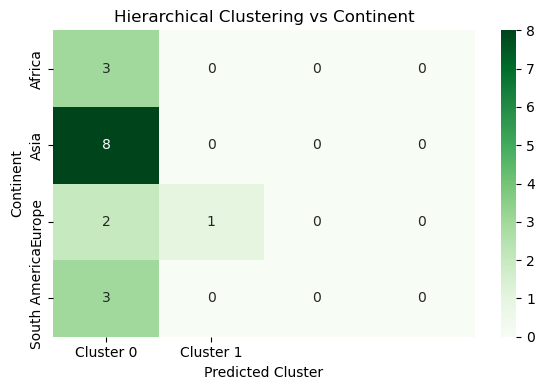

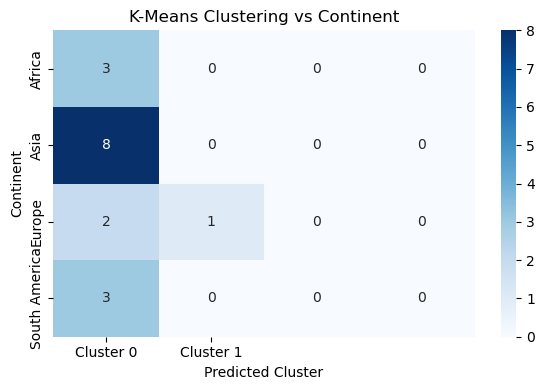

In [143]:
# Set 'Country' as index if present
if 'Country' in obesity_world_finaldata.columns:
    obesity_world_finaldata = obesity_world_finaldata.set_index('Country')

if 'Country' in sampled_obesity_data.columns:
    sampled_obesity_data = sampled_obesity_data.set_index('Country')

# Extract and clean continent labels
country_labels = obesity_world_finaldata.loc[sampled_obesity_data.index, 'Continent']
valid_idx = country_labels.dropna().index
country_labels = country_labels.loc[valid_idx]

label_encoder = LabelEncoder()
country_encoded = label_encoder.fit_transform(country_labels)

# Clustering
hc_clusters = cut_tree(linkage_scaled, n_clusters=2).flatten()  
kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
kmeans_clusters = kmeans.fit_predict(subset_obesity_scaled)

# Match Country labels
valid_positions = sampled_obesity_data.index.get_indexer(valid_idx)
hc_clusters_valid = hc_clusters[valid_positions]
kmeans_clusters_valid = kmeans_clusters[valid_positions]

# Calculate Confusion Matrices
cm_hc = confusion_matrix(country_encoded, hc_clusters_valid)
cm_kmeans = confusion_matrix(country_encoded, kmeans_clusters_valid)

# Results
plt.figure(figsize=(6, 4))
sns.heatmap(cm_hc,
            annot=True, fmt='d', cmap='Greens',
            xticklabels=[f"Cluster {i}" for i in sorted(set(hc_clusters_valid))],
            yticklabels=label_encoder.classes_)
plt.title("Hierarchical Clustering vs Continent")
plt.xlabel("Predicted Cluster")
plt.ylabel("Continent")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(cm_kmeans,
            annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Cluster {i}" for i in sorted(set(kmeans_clusters_valid))],
            yticklabels=label_encoder.classes_)
plt.title("K-Means Clustering vs Continent")
plt.xlabel("Predicted Cluster")
plt.ylabel("Continent")
plt.tight_layout()
plt.show()

Result: Both hierarchical and K-Means clustering grouped most countries into the same cluster, with little separation by continent. Countries from Africa, Asia, and South America were all placed in one cluster, while only one European country appeared in a different group.